In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from termcolor import colored

In [3]:
import book_format
book_format.set_style()
import kf_book.gh_internal as gh
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
from collections import namedtuple
from filterpy.common import Q_discrete_white_noise

Please install SymPy before continuing. See chapter 0 for instructions.


In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
method = "5"

# Data Preprocessing

In [6]:
def loader():
    # Load the measured value into this.
    weights1 = np.loadtxt("../tracking_data/method5.txt", delimiter=",")
    weights = list(weights1)
    
    # Load the actual data into this
    actual1 = np.loadtxt("../tracking_data/true_vals.txt", delimiter=",")
    actual = list(actual1)
    
    # Output the measured values as a list of N-D coordinates.
    return [weights, actual]

In [7]:
def initialize(weights):
    # Pre-process and calculate the intial values into this variable
    weight = 0
    gain_rate = 0
    
    # Output the initial estimates where
    # weight is a N-D coordinate and gain_rate is a N-D gradient.
    return [weight, gain_rate]

In [8]:
# This is the measured data got from sensors
# This is the actual data being given as annotations or label for prediction accuracy check
# Size of Actual Data = 1 + Size of Measured Data (according to convention here)

# weights = loader() # loading the data
[weights, actual] = loader()
weights = weights[1:]

# Objective Functions for Comparison

In [9]:
# Function to calculate mean squared distance between the estimated value and actual value
def msd(estimates, actual):
    msd = 0
    for i in range(len(actual)):
        msd += (estimates[i]-actual[i])**2;
    msd = msd / len(actual)
    msd = math.sqrt(msd)
    return msd

In [10]:
# Function to calculate absolute distance between the estimated value and actual value
def asd(estimates, actual):
    msd = 0
    for i in range(len(actual)):
        msd += abs(estimates[i]-actual[i]);
    msd = msd / len(actual)
    return msd

In [11]:
# Function to calculate KL Divergence of L1 normalized estimated and actual values
def kl_divergence(a, b):
    sum1 = sum(a)
    sum2 = sum(b)
    c = a
    d = b
    for i in range(len(a)):
        c[i] = a[i] / sum1
    for i in range(len(b)):
        d[i] = b[i] / sum2
    return sum(c[i] * np.log(c[i]/d[i]) for i in range(len(c)))

In [12]:
def objective(a, b):
    o1 = msd(a, b)
    o2 = asd(a, b)
    o3 = kl_divergence(a.copy(), b.copy())
    o4 = kl_divergence(b.copy(), a.copy())
    print("The Mean Squared Distance of estimates and actual path is "+ colored(o1, 'red', attrs=['bold','underline']))
    print("The Absolute Squared Distance of estimates and actual path is "+ colored(o2, 'red', attrs=['bold']))
    print("The KL Divergence between estimates and actual path is "+ colored(o3, 'red', attrs=['bold','underline']))
    print("The Inverse KL Divergence between estimates and actual path is "+ colored(o4, 'red', attrs=['bold']))
    return

In [13]:
[measured, acting] = loader()
objective(measured, acting)

The Mean Squared Distance of estimates and actual path is 0.05774385685535269
The Absolute Squared Distance of estimates and actual path is 0.050081896580097374
The KL Divergence between estimates and actual path is 2.0785096583655812e-07
The Inverse KL Divergence between estimates and actual path is 2.0785557865947736e-07


## Functions for Gaussian PDFs

In [14]:
## Used for defining the parameters for a gaussian
gaussian = namedtuple('Gaussian', ['mean', 'cov'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]}, Σ={s[1]})'

In [15]:
## Function for addition of two gaussians
## This is similar to convolution of two gaussians as well
def addition(g1, g2):
    n = len(g1.mean)
    mean1 = np.array(g1.mean)
    mean1.resize(n, 1)
    mean2 = np.array(g2.mean)
    mean2.resize(n, 1)
    cov1 = np.array(g1.cov)
    cov1.resize(n, n)
    cov2 = np.array(g2.cov)
    cov2.resize(n, n)
    mean = np.add(mean1, mean2)
    mean.resize(n)
    mean = list(mean)
    cov = np.add(cov1, cov2)
    cov = list(cov)
    return gaussian(mean, cov)

In [16]:
## Function for point wise multiplication of two gaussians
def product(g1, g2):
    n = len(g1.mean)
    mean1 = np.array(g1.mean)
    mean1.resize(n, 1)
    mean2 = np.array(g2.mean)
    mean2.resize(n, 1)
    cov1 = np.array(g1.cov)
    cov1.resize(n, n)
    cov2 = np.array(g2.cov)
    cov2.resize(n, n)
    mean = np.dot(cov2, np.dot(np.linalg.inv(np.add(cov1,cov2)), mean1))+np.dot(cov1, np.dot(np.linalg.inv(np.add(cov1,cov2)), mean2))
    mean.resize(n)
    mean = list(mean)
    cov = np.dot(cov1,np.dot(np.linalg.inv(np.add(cov1,cov2)),cov2))
    cov.resize(n, n)
    cov = list(cov)
    return gaussian(mean, cov)

# Kalman Filter

## Approach 1 - No velocity Updates and No outlier removal

### Algorithm

In [17]:
def kalman_filter(weights, position, process, sensor_var, do_print=False):
    estimates, predictions, uncertainty = [position.mean[0]], [], [position.cov[0]]
    
    for z in weights:
        # prediction step
        prior = addition(position, process)
        predictions.append(prior.mean[0])
        predicted_weight = prior.mean[0]

        # update step
        likelihood = gaussian([z], [sensor_var])
        position = product(prior, likelihood)
        
        estimates.append(position.mean[0])
        uncertainty.append(position.cov[0])
        estimated_weight = position.mean[0]
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions, uncertainty]

### Example 1

In [18]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The object is being expected to move with some velocity but the velocity is uncertain with this much amount
# This will be called as the variance of the process
process_var = 2.0**2

# The sensor measurement is also inaccurate and it results in some more uncertainty.
# This results in causing the sensor variance
sensor_var = 4.0**2

In [19]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 1.0 # initial velocity of the sensor
position = gaussian([weights[0]], [20.0**2])  # initial position and its uncertainty
process = gaussian([velocity], [process_var])  # initial gain and process uncertainty

In [20]:
estimates, predictions, uncertainty = kalman_filter(weights, position, process, sensor_var, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


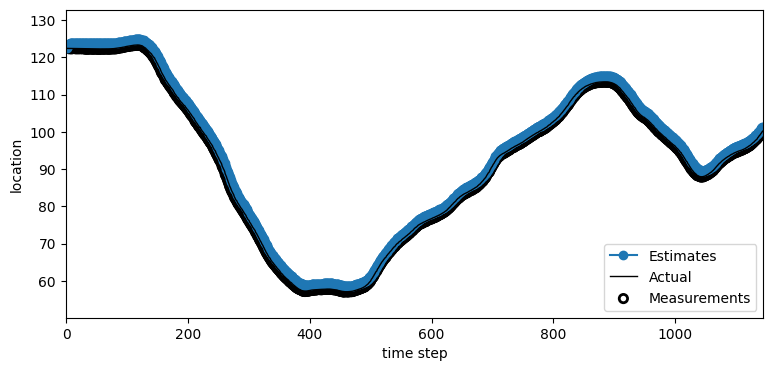

In [21]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a1e1.png")
plt.savefig("images_kalman/eps/method"+method+"_a1e1.eps")

In [22]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 1.6143559501495242
The Absolute Squared Distance of estimates and actual path is 1.5898464621365687
The KL Divergence between estimates and actual path is 1.2246726208057255e-05
The Inverse KL Divergence between estimates and actual path is 1.2227562230451889e-05


In [23]:
est = np.array(estimates)
np.savetxt("results_kalman/method"+method+"/estimates_variation1.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [24]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 5.0 # initial velocity of the sensor
position = gaussian([175], [20.0**2])  # initial position and its uncertainty
process = gaussian([velocity], [process_var])  # initial gain and process uncertainty

In [25]:
estimates, predictions, uncertainty = kalman_filter(weights, position, process, sensor_var, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


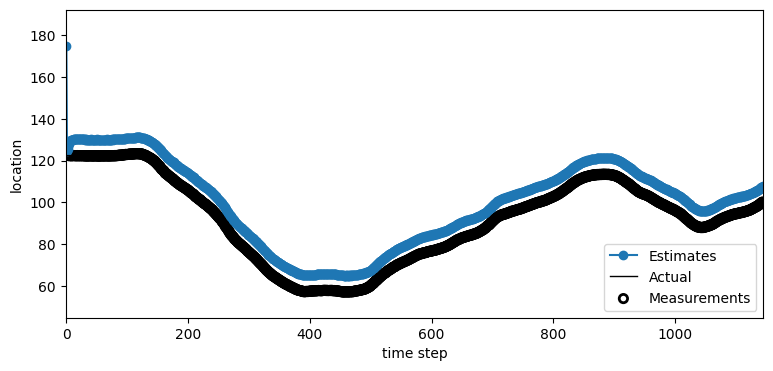

In [26]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a1e2.png")
plt.savefig("images_kalman/eps/method"+method+"_a1e2.eps")

In [27]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 7.982640335440317
The Absolute Squared Distance of estimates and actual path is 7.863809747921812
The KL Divergence between estimates and actual path is 0.00023660642169640595
The Inverse KL Divergence between estimates and actual path is 0.00023081810044587776


## Approach 2 - Point updates for velocity with outlier removal

### Algorithm

In [28]:
def kalman_filter_developed(weights, position, process, gain_rate, sensor_var, do_print=False):
    estimates, predictions, uncertainty = [position.mean[0]], [], [position.cov[0]]
    mean = np.mean(np.array(weights))
    sd = np.std(np.array(weights))
    
    for z in weights:
        previous_estimate = position
        
        # prediction step
        prior = addition(position, process)
        predictions.append(prior.mean[0])
        predicted_weight = prior.mean[0]

        # update step
        likelihood = 0
        if z>mean-sd and z<mean+sd:
            likelihood = gaussian([z], [sensor_var])
        else:
            likelihood = gaussian([previous_estimate.mean+process.mean], [sensor_var])
        position = product(prior, likelihood)
        new_velocity = (1 - gain_rate) * process.mean[0] + gain_rate * (position.mean[0] - previous_estimate.mean[0])
        process = gaussian([new_velocity], [process.cov[0]])
        
        estimates.append(position.mean[0])
        uncertainty.append(position.cov[0])
        estimated_weight = position.mean[0]
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions, uncertainty]

### Example 1

In [29]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The object is being expected to move with some velocity but the velocity is uncertain with this much amount
# This will be called as the variance of the process
process_var = 2.0**2

# The sensor measurement is also inaccurate and it results in some more uncertainty.
# This results in causing the sensor variance
sensor_var = 4.0**2

# gain-rate will be used for adaptive point updates for the velocity of the process
gain_rate = 4.0/10.0

In [30]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 1.0 # initial velocity of the sensor
position = gaussian([weights[0]], [20.0**2])  # initial position and its uncertainty
process = gaussian([velocity], [process_var])  # initial gain and process uncertainty

In [31]:
estimates, predictions, uncertainty = kalman_filter_developed(weights, position, process, gain_rate, sensor_var, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


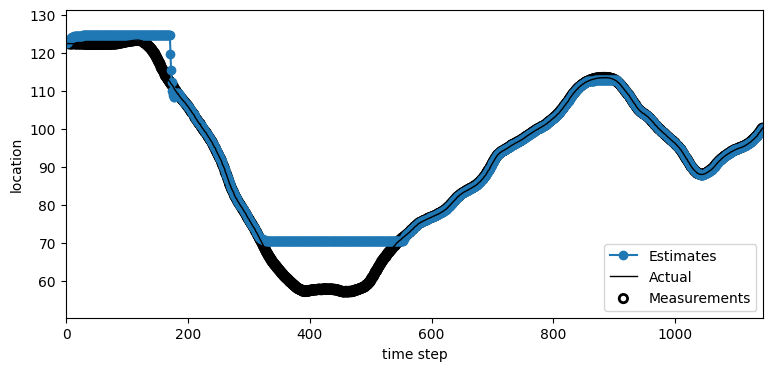

In [32]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a2e1.png")
plt.savefig("images_kalman/eps/method"+method+"_a2e1.eps")

In [33]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 4.922337067231089
The Absolute Squared Distance of estimates and actual path is 2.432952000510719
The KL Divergence between estimates and actual path is 0.001648369566109097
The Inverse KL Divergence between estimates and actual path is 0.0015753801761374698


In [34]:
est = np.array(estimates)
np.savetxt("results_kalman/method"+method+"/estimates_variation2.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [35]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 5.0 # initial velocity of the sensor
position = gaussian([175], [20.0**2])  # initial position and its uncertainty
process = gaussian([velocity], [process_var])  # initial gain and process uncertainty

In [36]:
estimates, predictions, uncertainty = kalman_filter_developed(weights, position, process, gain_rate, sensor_var, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


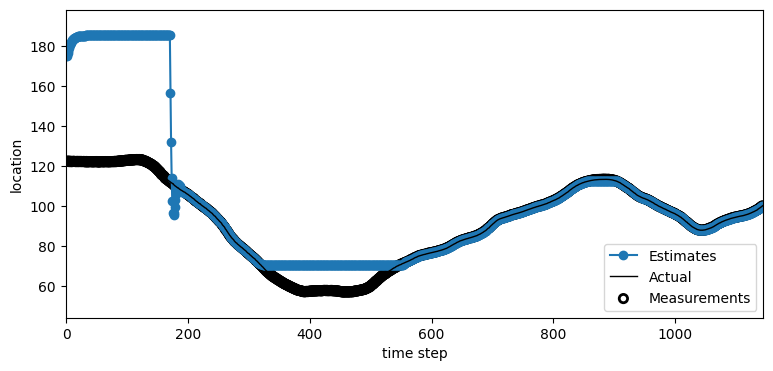

In [37]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a2e2.png")
plt.savefig("images_kalman/eps/method"+method+"_a2e2.eps")

In [38]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 25.11629574524708
The Absolute Squared Distance of estimates and actual path is 11.591391642364641
The KL Divergence between estimates and actual path is 0.016062895705316764
The Inverse KL Divergence between estimates and actual path is 0.015130243610069007


## Approach 3 - Multidimensional Kalman with Outlier removal

### Algorithm

In [39]:
def kalman_filter_developed2(weights, x, P, F, Q, H, R, do_print = False):
    estimates, predictions, uncertainty = [x[0]], [], [P[0][0]]
    mean = np.mean(np.array(weights))
    sd = np.std(np.array(weights))
    I = np.array([[1, 0],[0, 1]])
    
    for z in weights:
        previous_estimate = x
        
        # prediction step
        prior_mean = np.dot(F, x)
        prior_var = Q + np.dot(F, np.dot(P, F.T))
        predictions.append(prior_mean[0])
        predicted_weight = prior_mean[0]

        # update step
        pos = 0
        if z > mean-sd and z < mean+sd:
            pos = z
        else:
            pos = previous_estimate[0] + previous_estimate[1]
        
        y = pos - np.dot(H, prior_mean)
        K = np.dot(np.dot(prior_var, H.T), np.linalg.inv(R + np.dot(H, np.dot(prior_var, H.T))))
        x = prior_mean + np.dot(K, y)
        P = np.dot(I - np.dot(K, H), prior_var)
        
        estimates.append(x[0])
        uncertainty.append(P[0][0])
        estimated_weight = x[0]
        
        # Optional Printing Step
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
    
    return [estimates, predictions, uncertainty]

### Example 1

In [40]:
# Time Step on which data is being measured with respect to the the time step on which initial
# gain is being assumed.
time_step = 1.0  # day

# The object is being expected to move with some velocity but the velocity is uncertain with this much amount
# This will be called as the variance of the process
process_var = 2.0**2

# The object is being expected to move with some acceleration but the value is uncertain with this much amount
# This will be called as the variance of the velocity
velocity_var = 40.0**2

# The sensor measurement is also inaccurate and it results in some more uncertainty.
# This results in causing the sensor variance
sensor_var = 4.0**2

# These are some special matrices required for the computation in terms of multidimensional vectors
F = np.array([[1, 1], [0, 1]]) # This is the state transition function for considerations in position and velocity
Q = Q_discrete_white_noise(dim=2, dt=time_step, var=process_var) # This is the process covariance matrix denoted by White Noise
H = np.array([[1, 0]]) # This is the measurement function to be used in the update step
R = np.array([[sensor_var]]) # This is the measurement noise covariance matrix

In [41]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 1.0 # initial velocity of the sensor
x = np.array([weights[0], velocity]) # initial state containing position and velocity
P = np.array([[20.0**2, 0],[0, velocity_var]]) # initial process covariance matrix

In [42]:
estimates, predictions, uncertainty = kalman_filter_developed2(weights, x, P, F, Q, H, R, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


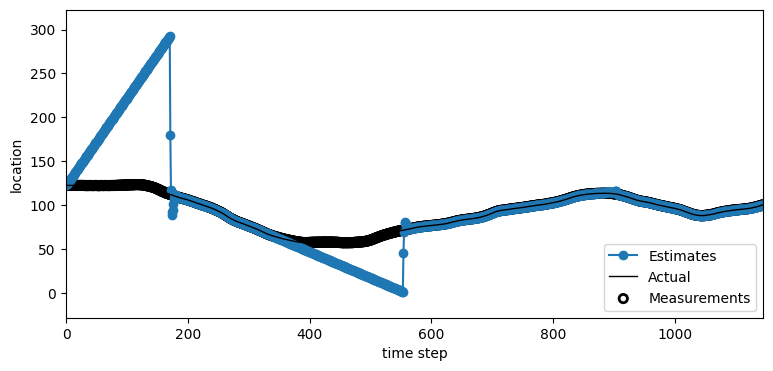

In [43]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a3e1.png")
plt.savefig("images_kalman/eps/method"+method+"_a3e1.eps")

In [44]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 41.518890678910374
The Absolute Squared Distance of estimates and actual path is 18.280048089009444
The KL Divergence between estimates and actual path is 0.07139051078783681
The Inverse KL Divergence between estimates and actual path is 0.09417939777452149


In [45]:
est = np.array(estimates)
np.savetxt("results_kalman/method"+method+"/estimates_variation3.txt",est,fmt="%10.5f",delimiter=',',newline=',')

### Example 2

In [46]:
# Intial Hypothesis made by some pre-processing of the measurement data
# weight, gain_rate = initialize(weights) # initializing the filter output

velocity = 5.0 # initial velocity of the sensor
x = np.array([175, velocity]) # initial state containing position and velocity
P = np.array([[20.0**2, 0],[0, velocity_var]]) # initial process covariance matrix

In [47]:
estimates, predictions, uncertainty = kalman_filter_developed2(weights, x, P, F, Q, H, R, do_print=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


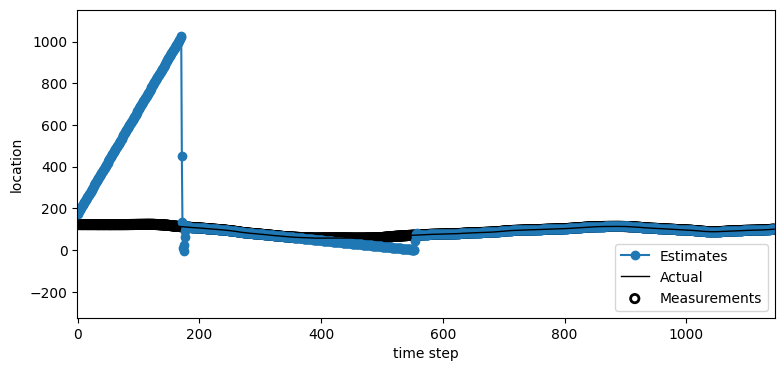

In [48]:
gh.plot_gh_results_manual2(weights, estimates, predictions, actual)
plt.savefig("images_kalman/png/method"+method+"_a3e2.png")
plt.savefig("images_kalman/eps/method"+method+"_a3e2.eps")

In [49]:
objective(estimates, actual)

The Mean Squared Distance of estimates and actual path is 209.22948863284194
The Absolute Squared Distance of estimates and actual path is 77.43914211160237
The KL Divergence between estimates and actual path is nan
The Inverse KL Divergence between estimates and actual path is nan


<ipython-input-11-c7d613123d74>:11: RuntimeWarning: invalid value encountered in log
  return sum(c[i] * np.log(c[i]/d[i]) for i in range(len(c)))
